In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Параметры
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 2

# Создаем модель LeNet
def create_lenet_model():
    model = keras.Sequential([
        # Первый сверточный блок
        layers.Conv2D(6, (5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        
        # Второй сверточный блок
        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Полносвязные слои
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

# Создаем модель
lenet_model = create_lenet_model()

# Компилируем модель
lenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("LeNet архитектура:")
lenet_model.summary()

LeNet архитектура:


C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     5,393,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,406,606 (20.62 MB)

 Trainable params: 5,406,606 (20.62 MB)

 Non-trainable params: 0 (0.00 B)

Подготовка данных

In [2]:
import os
import shutil
import random

def split_data(source_dir, output_dir, test_size=0.2, random_state=42):
    """
    
    """
    random.seed(random_state)
    
    # Создаем структуру папок
    train_dogs_dir = os.path.join(output_dir, 'train', 'dogs')
    train_cats_dir = os.path.join(output_dir, 'train', 'cats')
    val_dogs_dir = os.path.join(output_dir, 'validation', 'dogs')
    val_cats_dir = os.path.join(output_dir, 'validation', 'cats')
    
    # Создаем все необходимые директории
    for dir_path in [train_dogs_dir, train_cats_dir, val_dogs_dir, val_cats_dir]:
        os.makedirs(dir_path, exist_ok=True)
    
    # Пути к исходным папкам
    source_dogs_dir = os.path.join(source_dir, 'Dog')
    source_cats_dir = os.path.join(source_dir, 'Cat')
    
    # Функция для обработки одной категории
    def process_category_manual(source_category_dir, train_dir, val_dir):
        # Получаем список всех файлов в категории
        all_files = [f for f in os.listdir(source_category_dir) 
                    if os.path.isfile(os.path.join(source_category_dir, f))]
        
        # Перемешиваем файлы
        random.shuffle(all_files)
        
        # Вычисляем количество файлов для валидации
        val_count = int(len(all_files) * test_size)
        
        # Разделяем файлы
        val_files = all_files[:val_count]
        train_files = all_files[val_count:]
        
        # Копируем файлы в тренировочную папку
        for file in train_files:
            src = os.path.join(source_category_dir, file)
            dst = os.path.join(train_dir, file)
            shutil.copy2(src, dst)
        
        # Копируем файлы в валидационную папку
        for file in val_files:
            src = os.path.join(source_category_dir, file)
            dst = os.path.join(val_dir, file)
            shutil.copy2(src, dst)
        
        return len(train_files), len(val_files)
    
    # Обрабатываем собак и кошек
    print("Разделение данных...")
    train_dogs, val_dogs = process_category_manual(source_dogs_dir, train_dogs_dir, val_dogs_dir)
    train_cats, val_cats = process_category_manual(source_cats_dir, train_cats_dir, val_cats_dir)
    
    # Выводим статистику
    print("\n=== СТАТИСТИКА РАЗДЕЛЕНИЯ ===")
    print(f"Собаки: {train_dogs} тренировочных, {val_dogs} валидационных")
    print(f"Кошки: {train_cats} тренировочных, {val_cats} валидационных")
    print(f"Всего тренировочных: {train_dogs + train_cats}")
    print(f"Всего валидационных: {val_dogs + val_cats}")
    print(f"Общее количество: {train_dogs + train_cats + val_dogs + val_cats}")
    
    return {
        'train_dogs': train_dogs,
        'train_cats': train_cats,
        'val_dogs': val_dogs,
        'val_cats': val_cats
    }


In [3]:
source_directory = r'O:\temp'

output_directory = r'O:\Программирование\Repos\MLCourse\MLcourse\L16 Transfer learning\data'  

# Разделяем данные (80 train, 20 validation)
#stats = split_data(source_directory, output_directory, test_size=0.2)

In [4]:
# Предполагаем, что данные находятся в папках:
# data/train/dogs/
# data/train/cats/
# data/validation/dogs/
# data/validation/cats/

# Аугментация данных для тренировочного набора
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Только нормализация для валидационного набора
validation_datagen = ImageDataGenerator(rescale=1./255)

# Создаем генераторы данных
train_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    'data/validation/',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [5]:
import os
import shutil
from PIL import Image
import PIL

def filter_corrupted_images(source_dir):
    """
    Проверяет и удаляет поврежденные изображения
    """
    corrupted_count = 0
    total_count = 0
    
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                total_count += 1
                file_path = os.path.join(root, file)
                
                try:
                    # Пытаемся открыть изображение
                    with Image.open(file_path) as img:
                        img.verify()  # Проверяем целостность
                    # Для JPEG дополнительная проверка
                    if file.lower().endswith(('.jpg', '.jpeg')):
                        with Image.open(file_path) as img:
                            img.load()  # Загружаем данные
                except (PIL.UnidentifiedImageError, IOError, OSError, Exception) as e:
                    print(f"Поврежденное изображение: {file_path} - {e}")
                    os.remove(file_path)  # Удаляем поврежденный файл
                    corrupted_count += 1
    
    print(f"Проверено {total_count} файлов, удалено {corrupted_count} поврежденных")
    return corrupted_count

# Проверяем и очищаем данные перед обучением
print("Проверка изображений на повреждения...")
#filter_corrupted_images('data/train')
#filter_corrupted_images('data/validation')

Проверка изображений на повреждения...


LeNet

In [6]:
# Колбэки для обучения
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

# Обучаем модель LeNet
print("Обучение LeNet модели...")
lenet_history = lenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

# Сохраняем обученную модель LeNet
lenet_model.save('lenet_cats_dogs.h5')

# Оценка модели
lenet_loss, lenet_accuracy = lenet_model.evaluate(validation_generator)
print(f"LeNet точность на валидации: {lenet_accuracy:.4f}")

Обучение LeNet модели...
Epoch 1/10
476/625 ━━━━━━━━━━━━━━━━━━━━ 2:08 865ms/step - accuracy: 0.5720 - loss: 0.7246

C:\Users\akaku\AppData\Roaming\Python\Python313\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 601s 959ms/step - accuracy: 0.6125 - loss: 0.6586 - val_accuracy: 0.6881 - val_loss: 0.5886 - learning_rate: 0.0010
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 231s 370ms/step - accuracy: 0.6753 - loss: 0.6008 - val_accuracy: 0.7163 - val_loss: 0.5498 - learning_rate: 0.0010
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 233s 372ms/step - accuracy: 0.6970 - loss: 0.5726 - val_accuracy: 0.7459 - val_loss: 0.5105 - learning_rate: 0.0010
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 233s 373ms/step - accuracy: 0.7096 - loss: 0.5593 - val_accuracy: 0.7419 - val_loss: 0.5249 - learning_rate: 0.0010
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 230s 368ms/step - accuracy: 0.7248 - loss: 0.5406 - val_accuracy: 0.7623 - val_loss: 0.4919 - learning_rate: 0.0010
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 229s 366ms/step - accuracy: 0.7364 - loss: 0.5247 - val_accuracy: 0.7737 - val_loss: 0.4663 - learning_rate: 0.0010
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 230s 367ms/step - accuracy: 0.7448 

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8011 - loss: 0.4231
LeNet точность на валидации: 0.8011


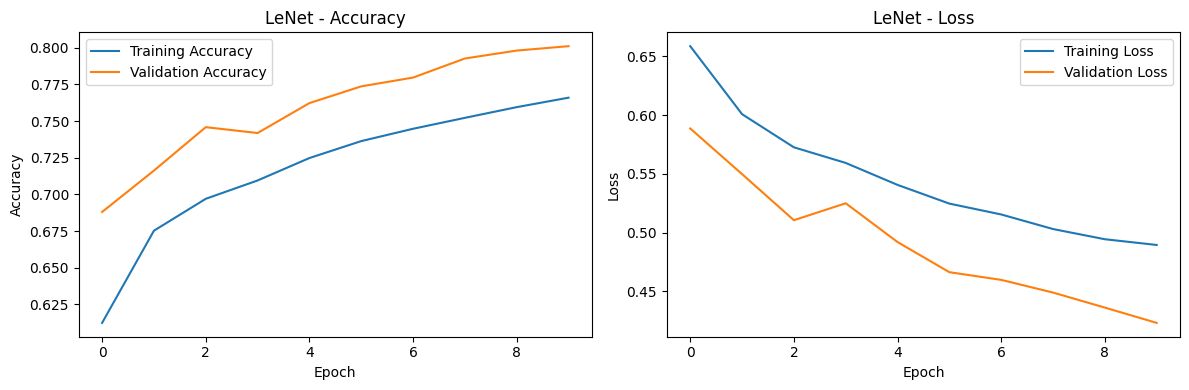

In [7]:
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # График точности
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # График потерь
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(lenet_history, 'LeNet')

In [8]:
def get_lenet_features_from_model(trained_lenet_model, data_generator):
    """
    Извлекает признаки из предпоследнего слоя обученной LeNet модели
    """
    # Для Sequential моделей создаем feature extractor по-другому
    feature_extractor = tf.keras.Sequential()
    
    # Добавляем все слои кроме последнего (выходного)
    for layer in trained_lenet_model.layers[:-1]:
        feature_extractor.add(layer)
    
    features_list = []
    labels_list = []
    
    # Сбрасываем генератор
    data_generator.reset()
    
    # Обрабатываем все батчи
    for i in range(len(data_generator)):
        images_batch, labels_batch = data_generator[i]
        
        # Извлекаем признаки
        batch_features = feature_extractor.predict(images_batch, verbose=0)
        
        features_list.append(batch_features)
        labels_list.append(labels_batch)
    
    # Объединяем все батчи
    all_features = np.concatenate(features_list, axis=0)
    all_labels = np.concatenate(labels_list, axis=0)
    
    print(f"Извлечено признаков: {all_features.shape}")
    return all_features, all_labels

def create_alexnet_with_lenet_features(lenet_feature_dim, num_classes=2):
    """
    Создает AlexNet модель, которая принимает признаки из LeNet как дополнительный вход
    """
    # Вход для изображений
    image_input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='image_input')
    
    # Вход для признаков из LeNet
    lenet_features_input = tf.keras.Input(shape=(lenet_feature_dim,), name='lenet_features_input')
    
    # AlexNet архитектура
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Преобразуем AlexNet features в вектор
    alexnet_features = tf.keras.layers.Flatten()(x)
    
    # Объединяем признаки AlexNet и LeNet
    combined_features = tf.keras.layers.concatenate([alexnet_features, lenet_features_input])
    
    # Классификатор
    x = tf.keras.layers.Dense(256, activation='relu')(combined_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    # Создаем модель с двумя входами
    model = tf.keras.Model(
        inputs=[image_input, lenet_features_input], 
        outputs=outputs
    )
    
    return model

Создание и обучение AlexNet с Transfer Learning

In [9]:
# Извлекаем признаки из обученной LeNet
print("Извлечение признаков для тренировочных данных...")
lenet_train_features, lenet_train_labels = get_lenet_features_from_model(lenet_model, train_generator)

print("Извлечение признаков для валидационных данных...")
lenet_val_features, lenet_val_labels = get_lenet_features_from_model(lenet_model, validation_generator)

# Создаем AlexNet модель
alexnet_model = create_alexnet_with_lenet_features(
    lenet_feature_dim=lenet_train_features.shape[1]
)

# Компилируем модель
alexnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



Извлечение признаков для тренировочных данных...
Извлечено признаков: (20000, 84)
Извлечение признаков для валидационных данных...
Извлечено признаков: (4998, 84)


In [10]:
# Подготавливаем данные для обучения
def prepare_data_for_training(image_generator, lenet_features):
    """
    Подготавливает данные в правильном формате
    """
    all_images = []
    all_labels = []
    
    image_generator.reset()
    
    for i in range(len(image_generator)):
        images_batch, labels_batch = image_generator[i]
        all_images.append(images_batch)
        all_labels.append(labels_batch)
    
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Обрезаем до минимальной длины
    min_length = min(len(all_images), len(lenet_features))
    all_images = all_images[:min_length]
    all_labels = all_labels[:min_length]
    lenet_features = lenet_features[:min_length]
    
    return [all_images, lenet_features], all_labels

print("Подготовка тренировочных данных...")
X_train, y_train = prepare_data_for_training(train_generator, lenet_train_features)

print("Подготовка валидационных данных...")
X_val, y_val = prepare_data_for_training(validation_generator, lenet_val_features)



Подготовка тренировочных данных...
Подготовка валидационных данных...


In [11]:
# Обучаем модель
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

print("Обучение AlexNet с Transfer Learning...")
alexnet_history = alexnet_model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# Сохраняем модель
alexnet_model.save('alexnet_with_lenet_features.h5')

Обучение AlexNet с Transfer Learning...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 471s 742ms/step - accuracy: 0.7434 - loss: 0.5257 - val_accuracy: 0.8027 - val_loss: 0.4292 - learning_rate: 1.0000e-04
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 428s 684ms/step - accuracy: 0.7806 - loss: 0.4671 - val_accuracy: 0.8057 - val_loss: 0.4182 - learning_rate: 1.0000e-04
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 429s 686ms/step - accuracy: 0.7943 - loss: 0.4465 - val_accuracy: 0.8101 - val_loss: 0.4115 - learning_rate: 1.0000e-04
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 425s 679ms/step - accuracy: 0.8130 - loss: 0.4169 - val_accuracy: 0.8013 - val_loss: 0.4414 - learning_rate: 1.0000e-04
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 424s 679ms/step - accuracy: 0.8389 - loss: 0.3705 - val_accuracy: 0.8071 - val_loss: 0.4444 - learning_rate: 1.0000e-04
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 425s 680ms/step - accuracy: 0.8802 - loss: 0.2850 - val_accuracy: 0.8071 - val_loss: 0.4757 - learning_rate: 5.0000e-05



ОЦЕНКА РЕЗУЛЬТАТОВ

=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ===
LeNet точность: 0.8011
AlexNet с Transfer Learning точность: 0.8101
Улучшение: 0.0090


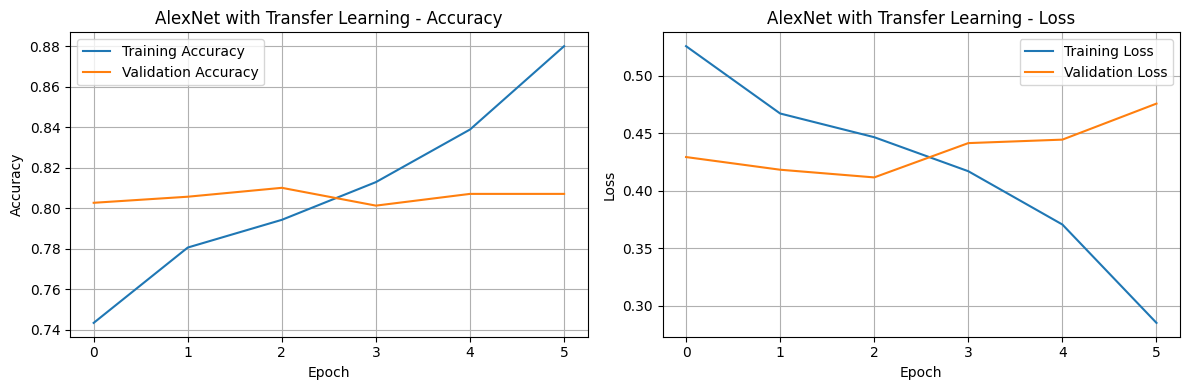

In [12]:
print("\n" + "=" * 50)
print("ОЦЕНКА РЕЗУЛЬТАТОВ")
print("=" * 50)

# Оцениваем AlexNet с transfer learning
alexnet_loss, alexnet_accuracy = alexnet_model.evaluate(X_val, y_val, verbose=0)

# Оцениваем оригинальную LeNet для сравнения
lenet_loss, lenet_accuracy = lenet_model.evaluate(validation_generator, verbose=0)

print("\n=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ===")
print(f"LeNet точность: {lenet_accuracy:.4f}")
print(f"AlexNet с Transfer Learning точность: {alexnet_accuracy:.4f}")
print(f"Улучшение: {alexnet_accuracy - lenet_accuracy:.4f}")

# Визуализация обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(alexnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(alexnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('AlexNet with Transfer Learning - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(alexnet_history.history['loss'], label='Training Loss')
plt.plot(alexnet_history.history['val_loss'], label='Validation Loss')
plt.title('AlexNet with Transfer Learning - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()